In [1]:
import glob
import os
import matplotlib.pylab as plt
import nibabel as nib
import numpy as np
from PIL import Image

In [2]:
DATA_DIR = "Task02_Heart"
IMAGE_FOLDER = "imagesTr"
LABEL_FOLDER = "labelsTr"

image_paths = sorted(glob.glob(os.path.join(DATA_DIR, IMAGE_FOLDER, "*.nii.gz")))
label_paths = sorted(glob.glob(os.path.join(DATA_DIR, LABEL_FOLDER, "*.nii.gz")))

In [3]:
def get_filename(path): 
    return path.split("\\")[-1]

def remove_file_extention(filename):
    return filename.split(".")[0]

filenames = [remove_file_extention(get_filename(path)) for path in image_paths]

filenames

['la_003',
 'la_004',
 'la_005',
 'la_007',
 'la_009',
 'la_010',
 'la_011',
 'la_014',
 'la_016',
 'la_017',
 'la_018',
 'la_019',
 'la_020',
 'la_021',
 'la_022',
 'la_023',
 'la_024',
 'la_026',
 'la_029',
 'la_030']

Load the files

In [4]:
images = [nib.load(path).get_fdata() for path in image_paths]
labels = [nib.load(path).get_fdata() for path in label_paths]

Look at some slices from the first image in the dataset

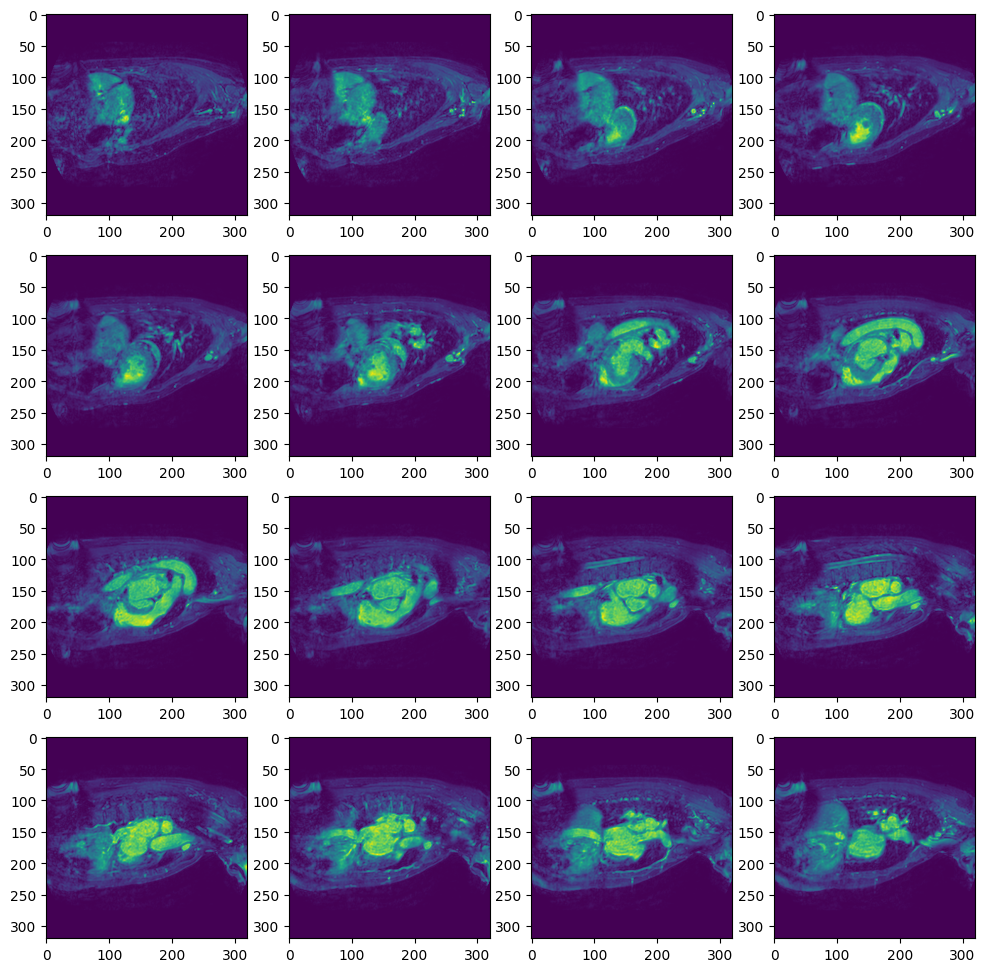

In [5]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(images[1][:,:,i*6])

Find where the heart is located in the images

In [6]:
def get_bounds(label, value):
    """
    Takes an 3D numpy array and returns a list of tuples containing the upper and lower bounds for each dimention. 
    For each dimention, it iterates over slices of the array until the first and last occruances of the specified value. 
    The indecis of this occurances define the bounds. <br>
    <br>
    Param label is an ND numpy array. <br>
    Param value is a value that specifies the bounds <br>
    Returns a 2D numpy array that contains an array for each dimention of the input label. 
    Each array contains the lower and upper bounds for that dimention respectivly.
    """
    shape = label.shape
    bounds = []
    for d in range(len(shape)):
        slices = np.rollaxis(label, d)
        lower = None
        upper = None
        for i in range(shape[d]):
            if value in slices[i]:
                lower = i
                break
        for i in reversed(range(shape[d])):
            if value in slices[i]:
                upper = i
                break
        bounds.append((lower, upper))
    return bounds

label_bounds = [get_bounds(label, 1) for label in labels]

print(f"For the first image, the heart is located between the following positions:")
for dimention, bounds in enumerate(label_bounds[0]):
    print(f"  between positions {bounds[0]} and {bounds[1]} in dimention {dimention+1}")

For the first image, the heart is located between the following positions:
  between positions 115 and 159 in dimention 1
  between positions 151 and 209 in dimention 2
  between positions 45 and 110 in dimention 3


Scale values of images

In [12]:
def scale(array, input_range, output_range=None):
    input_min, input_max = input_range
    zero_to_one = (array - input_min) / (input_max - input_min)
    if output_range is None:
        return zero_to_one
    
    output_min, output_max = output_range
    return zero_to_one * (output_max - output_min) + output_min

image_max = max([image.max() for image in images])
image_min = min([image.min() for image in images])

label_max = max([label.max() for label in labels])
label_min = min([label.min() for label in labels])

scaled_images = [scale(image, (image_min, image_max), (0, 255)) for image in images]
scaled_labels = [scale(label, (label_min, label_max), (0, 255)) for label in labels]

int_images = [np.uint8(image) for image in scaled_images]
int_labels = [np.uint8(label) for label in scaled_labels]

Select positions in the images where to slice

In [17]:
DIMENTION = 2
AMOUNT = 3
STEP = 10

def seq(first, step, length):
    return np.array([first + index * step for index in range(length)])

dimention_bounds = [bounds[DIMENTION] for bounds in label_bounds]
sizes = [upper - lower for lower, upper in dimention_bounds]
middels = [(lower + ((upper - lower)//2)) for lower, upper in dimention_bounds]
deviations = np.int32(np.random.normal(loc=0, scale=10, size=(len(images))))
int_slices = np.array([seq(mid-STEP, STEP, AMOUNT) + dev for mid, dev in zip(middels, deviations)])

print(f"The first image will be sliced at positions {int_slices[0]}")

The first image will be sliced at positions [71 81 91]


Select slices from the images

In [21]:
def select(image, label, slices, filename=None):
    return [{
                "image": image[:,:,pos], 
                "label": label[:,:,pos],
                "position": pos,
                "input_filename": filename,
                "output_filename": f"{filename}_pos_{pos}" 
            } for pos in slices]    

selected = [select(image, label, slices, filename) 
            for image, label, slices, filename
            in zip(int_images, int_labels, int_slices, filenames)]

Saving selected slices

In [22]:
def save(selected, folder):
    for info_list in selected:
        makedir(os.path.join(folder, "images"))
        makedir(os.path.join(folder, "labels"))

        for entry in info_list:
            image = Image.fromarray(entry["image"])
            label = Image.fromarray(entry["label"])
            filename = entry["output_filename"] + ".png"
            image.save(os.path.join(folder, "images", filename))
            label.save(os.path.join(folder, "labels", filename))

def makedir(path):
    os.makedirs(os.path.join(os.getcwd(), path), exist_ok=True)

FOLDER = "dataset"

save(selected, FOLDER)